In [4]:
pip install yfinance

     |████████████████████████████████| 6.3MB 16.7MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23455 sha256=5157a35119288f97cedfe36d4712f4deb3a4140591e18de0fbd83f2827de25a4
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [5]:
pip install ta

  Created wheel for ta: filename=ta-0.7.0-cp37-none-any.whl size=28716 sha256=a6541ae16010aa11b73af5e61c801b00cca4eeb28f8d7c62c49850bed785f982
  Stored in directory: /root/.cache/pip/wheels/dd/88/30/de9553fb54a474eb7480b937cdbb140bdda613d29cf4da7994
Successfully built ta


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import numpy as np 
import yfinance as yf
from datetime import datetime
import fastai.tabular 
from ta import add_all_ta_features

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso

from sklearn.model_selection import GridSearchCV

ImportError: ignored

In [7]:
stocks = ['AMZN', 'VEDL.NS', 'TCS.NS', 'ONGC.NS', 'TSLA', 'LT.NS']

for stock in stocks:
  stock_data = yf.Ticker(stock)
  df = stock_data.history(interval='1d', start='2015-4-29', end='2021-4-29')
  df.to_csv('data_' + stock +'.csv')

In [41]:
def create_model(stock, shift):
  df = pd.read_csv(f'data_{stock}.csv')
  
  date_change = '%Y-%m-%d'
    
  df['Date'] = pd.to_datetime(df['Date'], format = date_change)
  dates = df['Date']

  df = add_all_ta_features(df, "Open", "High", "Low", "Close", "Volume", fillna=True)

  fastai.tabular.add_datepart(df,'Date', drop = 'True')
  df['Date'] = pd.to_datetime(df.index.values, format = date_change)
  fastai.tabular.add_cyclic_datepart(df, 'Date', drop = 'True')

  df.insert(0,'Dates',dates)

  # Training models
  shift = -shift
  df['Close_lag'] = df['Close'].shift(shift)

  train_pct = .75
  train_pt = int(len(df)*train_pct)
  if train_pt < 400:
    train_pt = train_pt = int(len(df)*.5)
  train = df.iloc[:train_pt,:]
  test = df.iloc[train_pt:,:]
        
  x_train = train.iloc[:shift,1:-1]
  y_train = train['Close_lag'][:shift]
  x_test = test.iloc[:shift,1:-1]
  y_test = test['Close'][:shift]

  # Linear Regression

  lr = LinearRegression()
  lr.fit(x_train, y_train)
  lr_pred = lr.predict(x_test)
  lr_r2 = lr.score(x_test, y_test)
  lr_MSE = mean_squared_error(y_test, lr_pred)
  print("Linear Regression R2 Score --> " + str(lr_r2))
  print("Linear Regression MSE Score --> " + str(lr_MSE))

  plt.figure(figsize=(15,5))
  plt.plot(test['Dates'],test['Close'], label = "True Test Data")
  plt.plot(test['Dates'][:shift], lr_pred, label = "prediction")
  plt.legend()
  plt.ylabel('Close')
  plt.title('Linear Regression - ' + stock + ' - ' + str(shift))
  plt.tight_layout()
  plt.savefig('Linear Regression - ' + stock + ' - ' + str(shift) + '.png')
  plt.figure(0)
  plt.show()

  # Multilayer Perceptron

  ss = StandardScaler()
  scaled_x_train = ss.fit_transform(x_train)
  scaled_x_test = ss.transform(x_test)

  mlp = MLPRegressor(random_state=1, max_iter=1000, hidden_layer_sizes = (100,), activation = 'identity',learning_rate = 'adaptive')
  mlp.fit(scaled_x_train, y_train)
  mlp_pred = mlp.predict(scaled_x_test)
  mlp_r2 = mlp.score(scaled_x_test, y_test)
  mlp_MSE = mean_squared_error(y_test, mlp_pred)
  print("Multilayer Perceptron R2 Score --> " + str(mlp_r2))
  print("Multilayer Perceptron MSE Score --> " + str(mlp_MSE))

  plt.figure(figsize=(15,5))
  plt.plot(test['Dates'],test['Close'], label = "True Test Data")
  plt.plot(test['Dates'][:shift], mlp_pred, label = "prediction")
  plt.legend()
  plt.ylabel('Close')
  plt.title('Multilayer Perceptron - ' + stock + ' - ' + str(shift))
  plt.tight_layout()
  plt.savefig('Multilayer Perceptron - ' + stock + ' - ' + str(shift) + '.png')
  plt.figure(1)
  plt.show()

  # Random Forest Regression
  parameter_space = { 'bootstrap': [True, False],
                      'max_depth': [3,4,5],
                      'max_features': ['auto', 'sqrt'],
                      'min_samples_leaf': [1, 2, 4],
                      'min_samples_split': [2, 5, 10],
                      'n_estimators': [100,200,300]}

  rfr = RandomForestRegressor(random_state=1)
  rfr_gs = GridSearchCV(rfr, parameter_space, n_jobs=-1, cv=[(slice(None), slice(None))])
  rfr_gs.fit(x_train, y_train)
  rfr_pred = rfr_gs.predict(x_test)
  rfr_r2 = rfr_gs.score(x_test, y_test)
  rfr_MSE = mean_squared_error(y_test, rfr_pred)
  print("Random Forest Regression R2 Score --> " + str(rfr_r2))
  print("Random Forest Regression MSE Score --> " + str(rfr_MSE))

  plt.figure(figsize=(15,5))
  plt.plot(test['Dates'],test['Close'], label = "True Test Data")
  plt.plot(test['Dates'][:shift], rfr_pred, label = "prediction")
  plt.legend()
  plt.ylabel('Close')
  plt.title('Random Forest Regressor - ' + stock + ' - ' + str(shift))
  plt.tight_layout()
  plt.savefig('Random Forest Regressor - ' + stock + ' - ' + str(shift) + '.png')
  plt.figure(1)
  plt.show()

/usr/local/lib/python3.7/dist-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/usr/local/lib/python3.7/dist-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
/usr/local/lib/python3.7/dist-packages/fastai/tabular/transform.py:63: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  for n in attr: df[prefix + n] = getattr(field.dt, n.lower())


Linear Regression R2 Score --> 0.9841369168908146
Linear Regression MSE Score --> 5668.687996004875


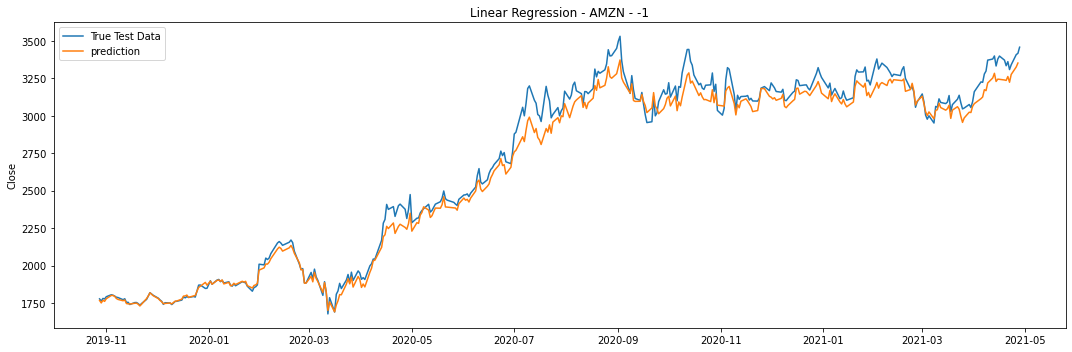

<Figure size 432x288 with 0 Axes>

Multilayer Perceptron R2 Score --> 0.9967007219268287
Multilayer Perceptron MSE Score --> 1179.000190576975


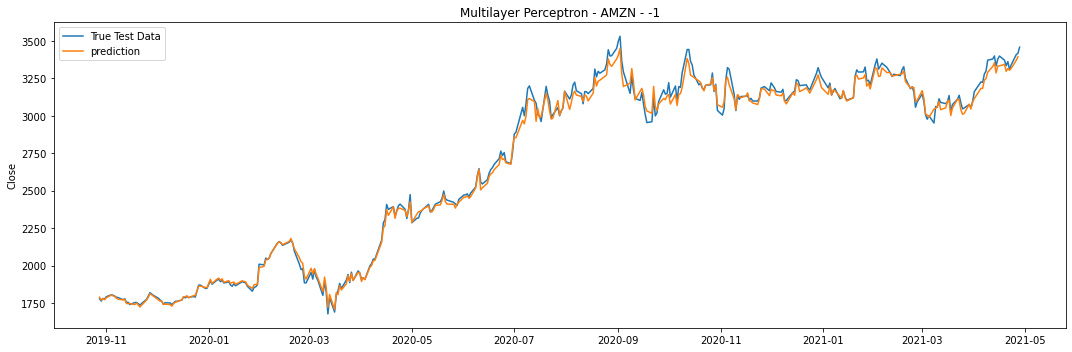

Random Forest Regression R2 Score --> -1.3418266314718261
Random Forest Regression MSE Score --> 836853.9976230772


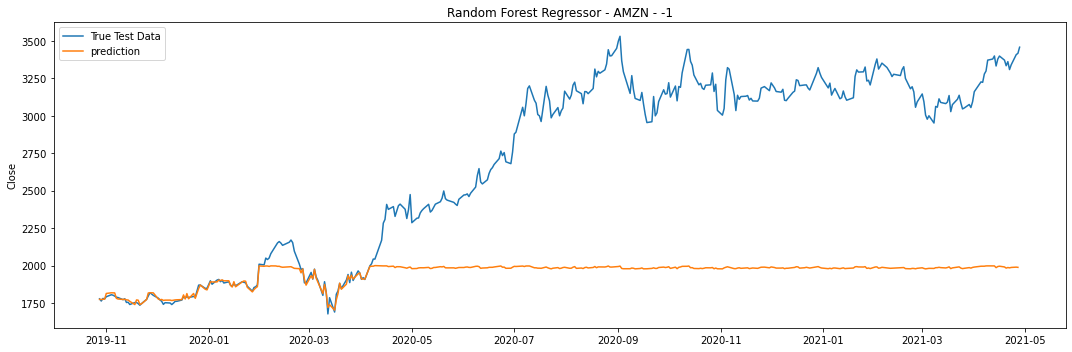

In [42]:
create_model('AMZN', 1)

/usr/local/lib/python3.7/dist-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/usr/local/lib/python3.7/dist-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
/usr/local/lib/python3.7/dist-packages/fastai/tabular/transform.py:63: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  for n in attr: df[prefix + n] = getattr(field.dt, n.lower())


Linear Regression R2 Score --> 0.938683711079959
Linear Regression MSE Score --> 21832.764064721076


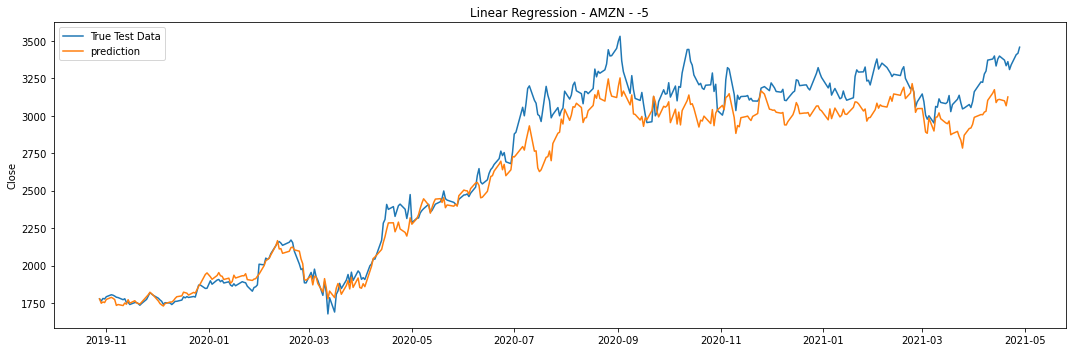

<Figure size 432x288 with 0 Axes>

Multilayer Perceptron R2 Score --> 0.9831952695386125
Multilayer Perceptron MSE Score --> 5983.62558786215


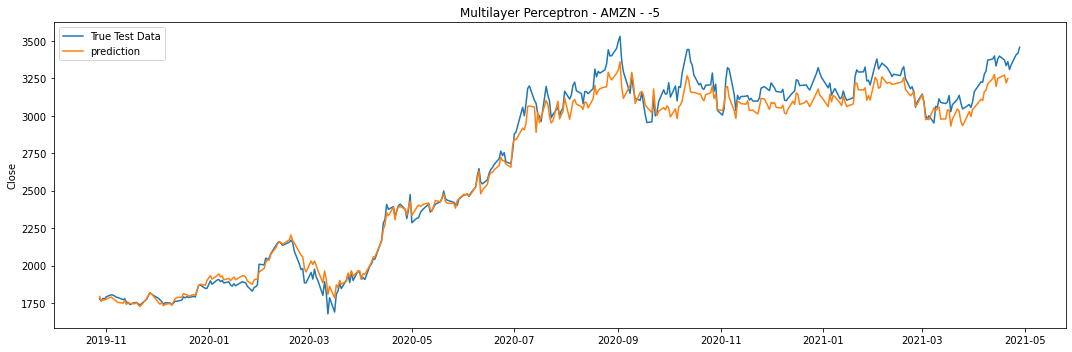

Random Forest Regression R2 Score --> -1.721219841879237
Random Forest Regression MSE Score --> 968939.115892391


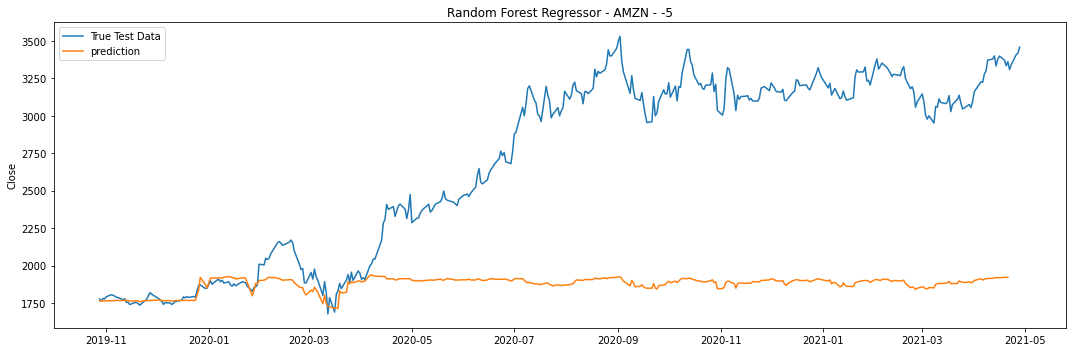

In [43]:
create_model('AMZN', 5)

/usr/local/lib/python3.7/dist-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/usr/local/lib/python3.7/dist-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
/usr/local/lib/python3.7/dist-packages/fastai/tabular/transform.py:63: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  for n in attr: df[prefix + n] = getattr(field.dt, n.lower())


Linear Regression R2 Score --> 0.890847608659659
Linear Regression MSE Score --> 38670.76479850318


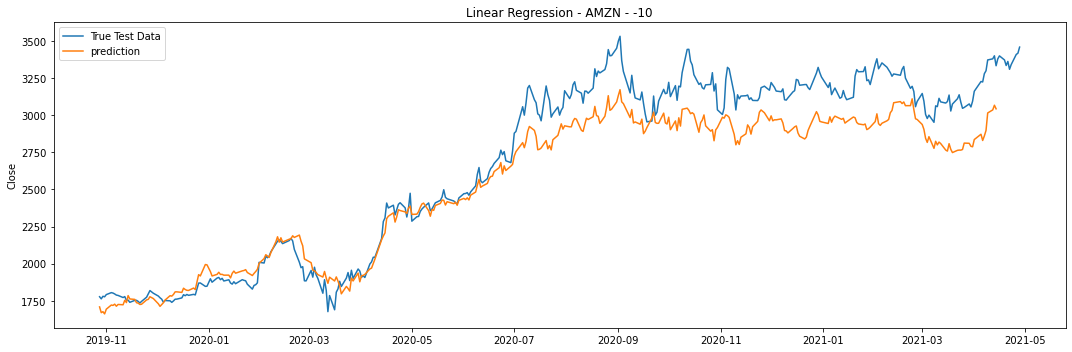

<Figure size 432x288 with 0 Axes>

Multilayer Perceptron R2 Score --> 0.9622273886552277
Multilayer Perceptron MSE Score --> 13382.16919668266


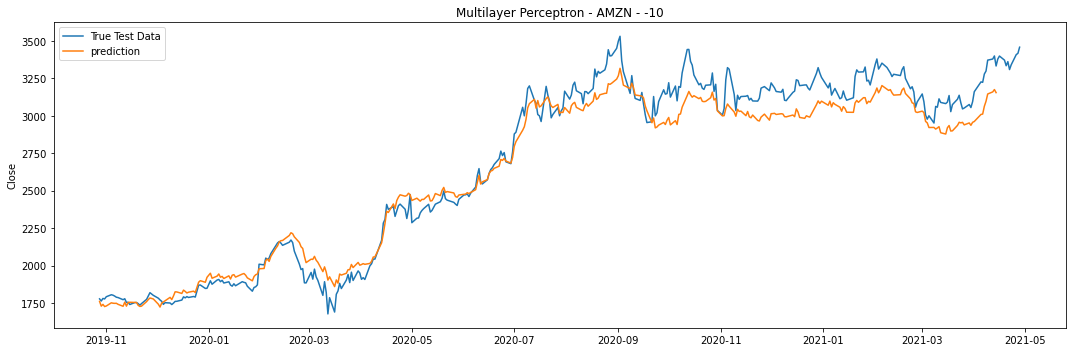

Random Forest Regression R2 Score --> -1.9635613206138705
Random Forest Regression MSE Score --> 1049937.4442293586


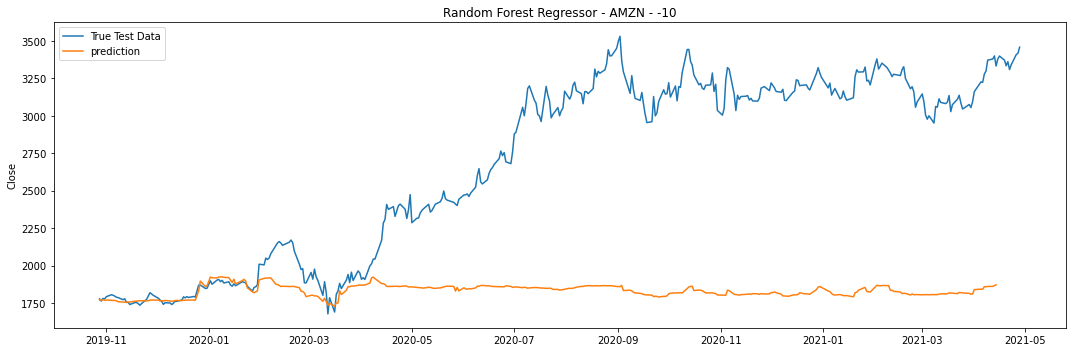

In [44]:
create_model('AMZN', 10)

/usr/local/lib/python3.7/dist-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/usr/local/lib/python3.7/dist-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
/usr/local/lib/python3.7/dist-packages/fastai/tabular/transform.py:63: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  for n in attr: df[prefix + n] = getattr(field.dt, n.lower())


Linear Regression R2 Score --> 0.9653758206467278


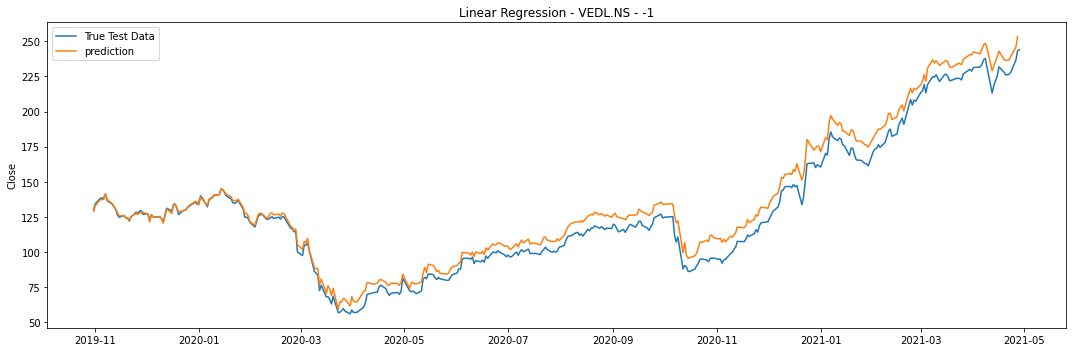

<Figure size 432x288 with 0 Axes>

Multilayer Perceptron R2 Score --> 0.9865221115429736


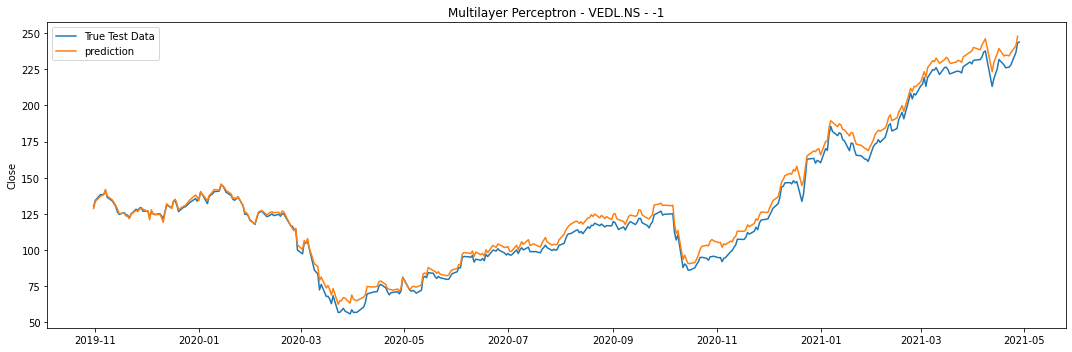

Random Forest Regression R2 Score --> 0.9978337801250723


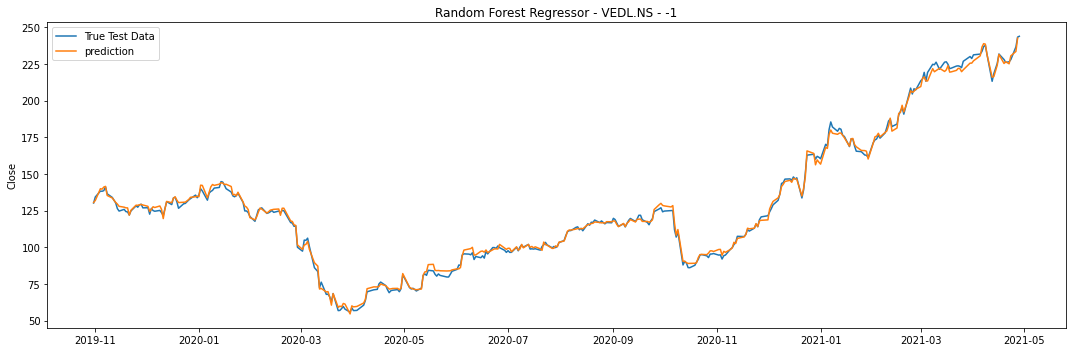

In [ ]:
create_model('VEDL.NS', 1)

/usr/local/lib/python3.7/dist-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/usr/local/lib/python3.7/dist-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
/usr/local/lib/python3.7/dist-packages/fastai/tabular/transform.py:63: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  for n in attr: df[prefix + n] = getattr(field.dt, n.lower())


Linear Regression R2 Score --> 0.1376554276758677


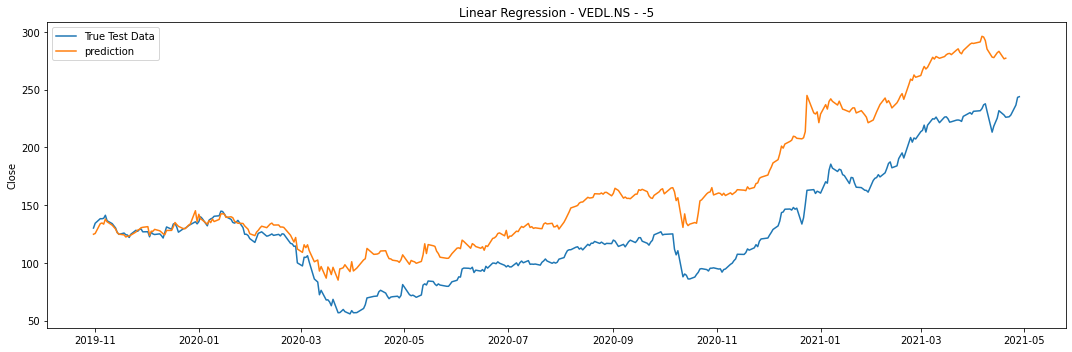

<Figure size 432x288 with 0 Axes>

Multilayer Perceptron R2 Score --> 0.8651212377257733


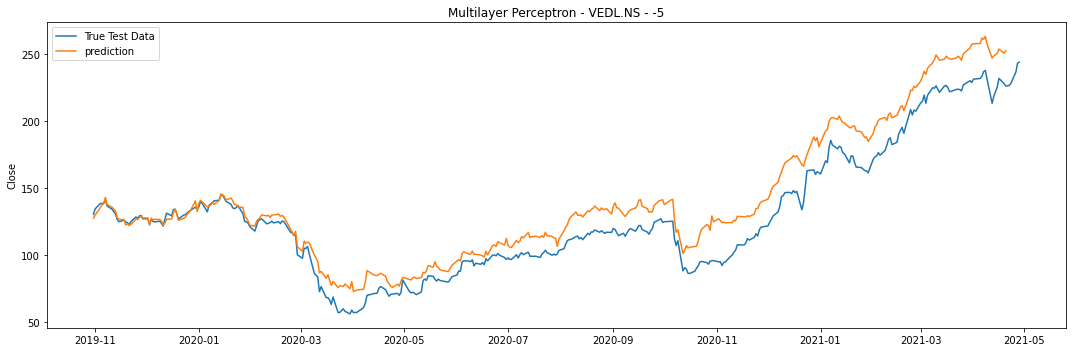

Random Forest Regression R2 Score --> 0.9709557436742864


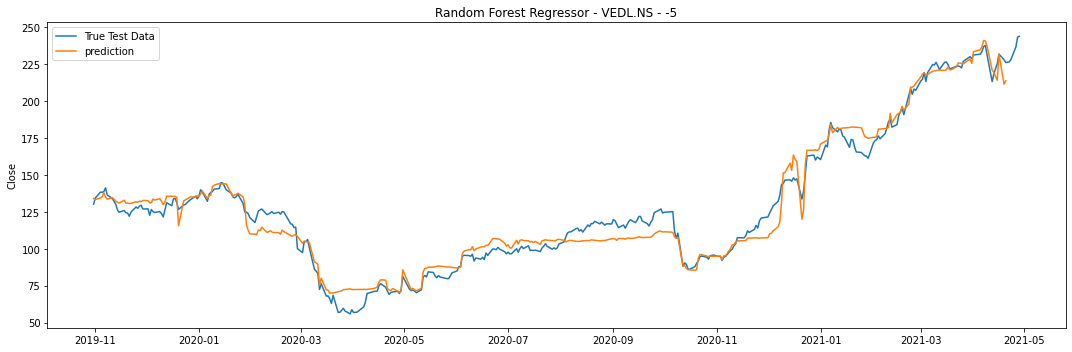

In [ ]:
create_model('VEDL.NS', 5)

/usr/local/lib/python3.7/dist-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/usr/local/lib/python3.7/dist-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
/usr/local/lib/python3.7/dist-packages/fastai/tabular/transform.py:63: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  for n in attr: df[prefix + n] = getattr(field.dt, n.lower())


Linear Regression R2 Score --> -2.077111963267234


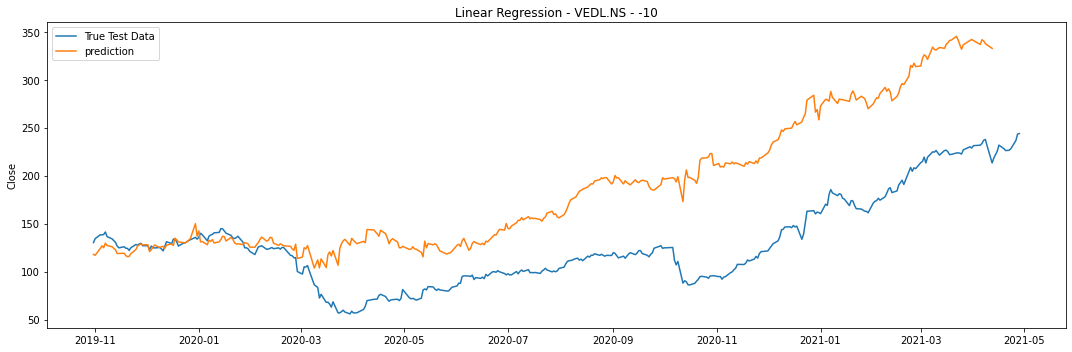

<Figure size 432x288 with 0 Axes>

Multilayer Perceptron R2 Score --> 0.4678123624548519


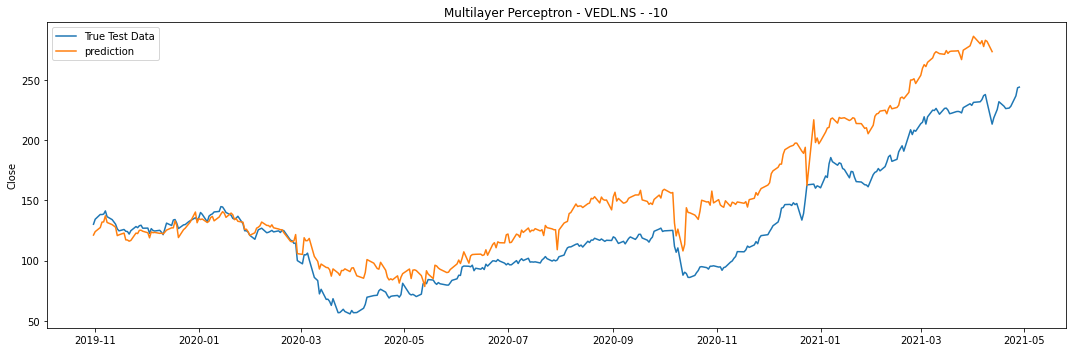

Random Forest Regression R2 Score --> 0.7828684394846064


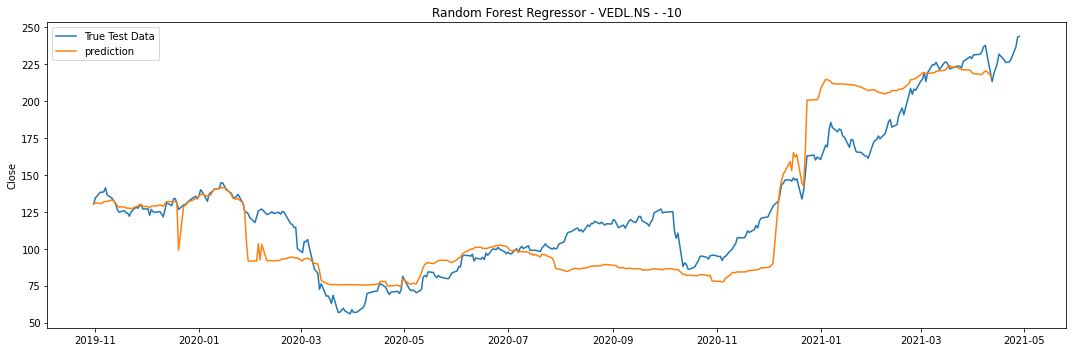

In [ ]:
create_model('VEDL.NS', 10)